<a href="https://colab.research.google.com/github/kluless13/paper2/blob/main/fishtally_polygon_customisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Dependencies

In [1]:
!nvidia-smi

Wed Dec 20 13:12:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 26.2/166.8 GB disk)


In [5]:
!pip install supervision==0.2.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.2.0


### FishTally - Polygon Customisation

In [6]:
SOURCE_VIDEO_PATH = "/content/Tang.mp4"

In [7]:
from ultralytics import YOLO
# multiclass weights
model = YOLO('/content/multiclass-wts.pt')

In [8]:
CLASS_NAMES = model.model.names
print(CLASS_NAMES)

{0: 'Blue-Tang', 1: 'Orange-Clown', 2: 'Three-Striped-Damselfish', 3: 'Yellow-Tang'}



WARNING ⚠️ NMS time limit 0.550s exceeded
0: 736x1280 20 Yellow-Tangs, 76.5ms
Speed: 9.4ms preprocess, 76.5ms inference, 739.3ms postprocess per image at shape (1, 3, 736, 1280)


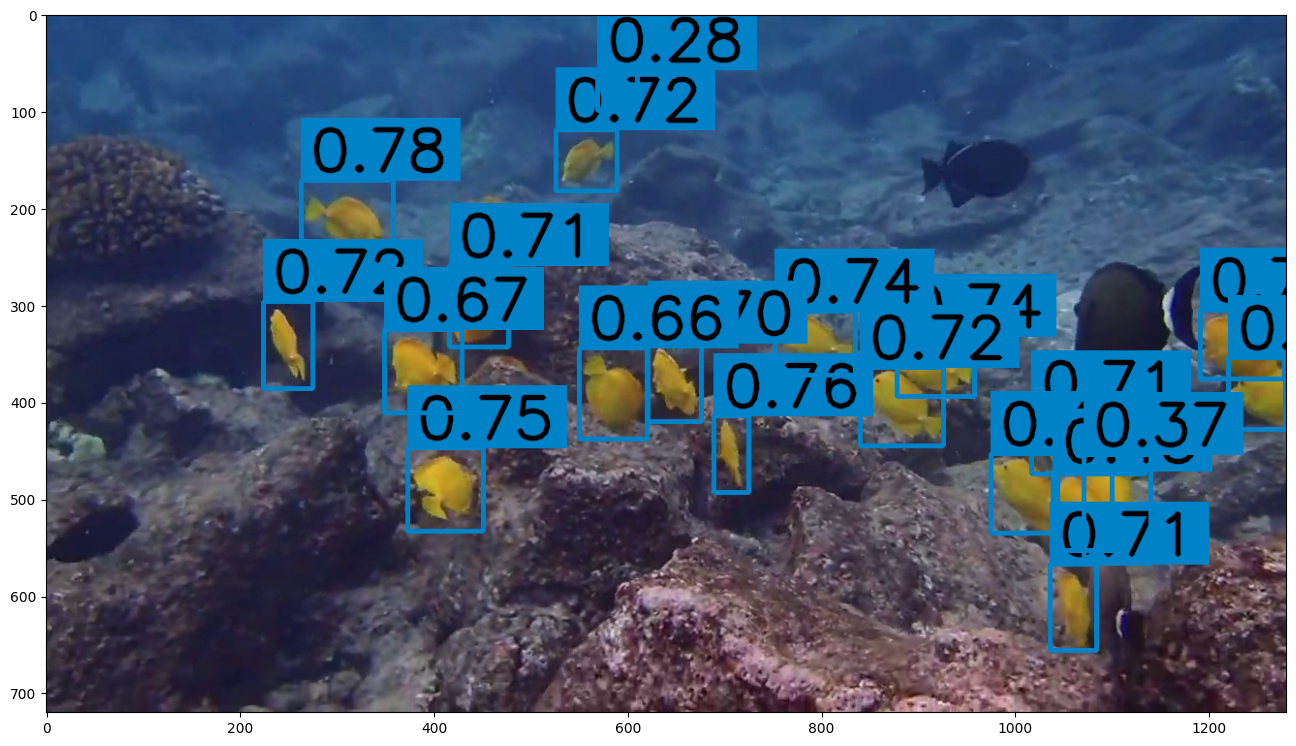

In [10]:
import supervision as sv

# extract video frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
frame = box_annotator.annotate(scene=frame, detections=detections)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [9]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=29, total_frames=269)

Creating a tracker and polygon


0: 736x1280 20 Yellow-Tangs, 73.7ms
Speed: 6.8ms preprocess, 73.7ms inference, 4.8ms postprocess per image at shape (1, 3, 736, 1280)


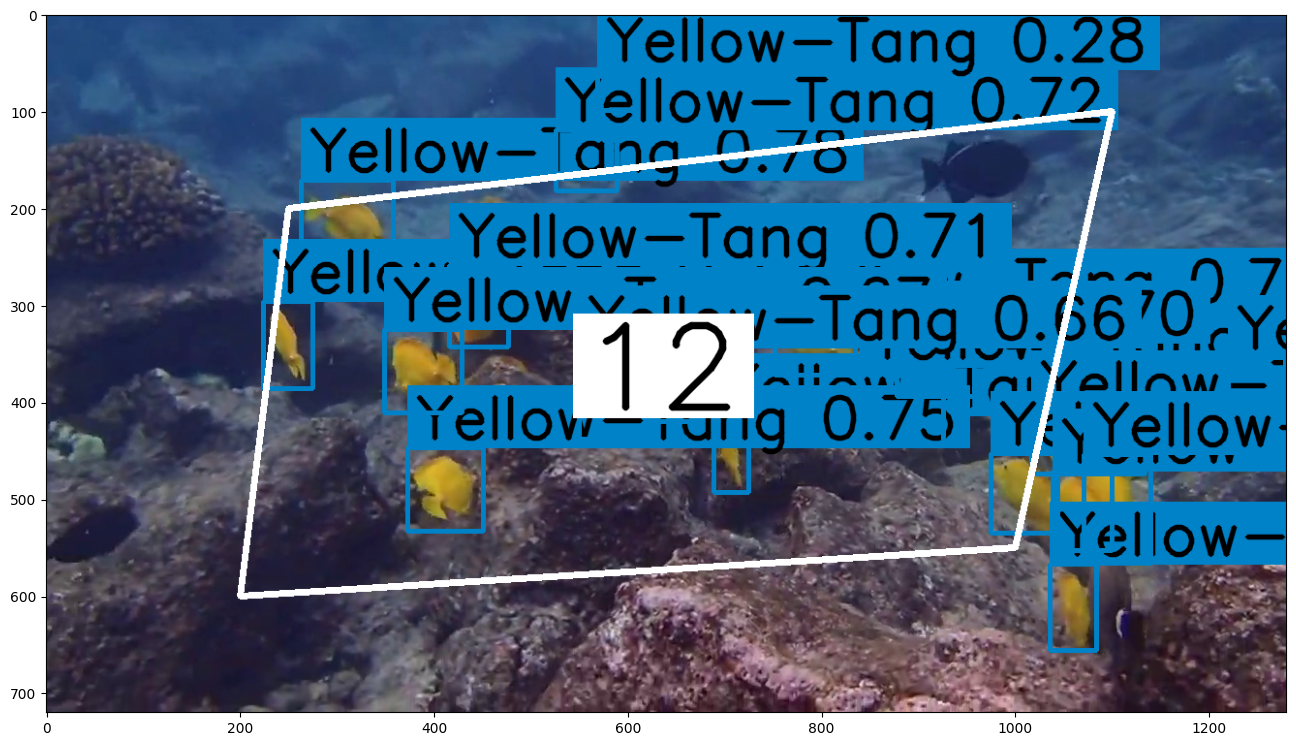

In [11]:
import numpy as np
import supervision as sv

# initiate polygon zone
polygon = np.array([
    [200,600],
    [250,200],
    [1100,100],
    [1000,550]
])
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

# extract video frame
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
iterator = iter(generator)
frame = next(iterator)

# detect
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_yolov8(results)
detections = detections[detections.class_id == 3]
zone.trigger(detections=detections)

# annotate
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
frame = zone_annotator.annotate(scene=frame)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [12]:
import numpy as np
import supervision as sv

# initiate polygon zone
polygon = np.array([
    [200,600],
    [250,200],
    [1100,100],
    [1000,550]
])
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

# initiate annotators
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=4)

def process_frame(frame: np.ndarray, _) -> np.ndarray:
    # detect
    results = model(frame, imgsz=1280)[0]
    detections = sv.Detections.from_yolov8(results)
    detections = detections[detections.class_id == 3]
    zone.trigger(detections=detections)

    # annotate
    box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=1)
    labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, confidence, class_id, _ in detections]
    frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
    frame = zone_annotator.annotate(scene=frame)

    return frame

sv.process_video(source_path=SOURCE_VIDEO_PATH, target_path="/content/polygon-result.mp4", callback=process_frame)

from IPython import display
display.clear_output()